In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageFile
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/test'

Image.MAX_IMAGE_PIXELS = None  

Image.MAX_IMAGE_PIXELS = 200000000 

def convert_to_rgb(image):
    if image.mode == 'P':  
        image = image.convert("RGBA")  
    if image.mode == "RGBA":  
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")  
    return image


def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)  
    return image

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  
    transforms.Lambda(convert_to_rgb),               
    transforms.RandomResizedCrop(224),               
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomVerticalFlip(p=0.2),            
    transforms.RandomRotation(degrees=15),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),                          
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])



val_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  
    transforms.Lambda(convert_to_rgb),  
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),              
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

ImageFile.LOAD_TRUNCATED_IMAGES = True

MIN_IMAGE_FILE_SIZE = 3284  # 1 KB (adjust as needed)

def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        
        with Image.open(file_path) as img:
            img.verify()  
        return True
    except (OSError, Image.DecompressionBombError):
        return False


class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        # Filter out invalid images
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

dataset = ValidImageFolder(root=data_dir, transform=val_transform)

In [3]:
batch_size=512

test_loader = DataLoader(dataset, batch_size=128, shuffle=False)

print(f"Test Dataset Size: {len(test_loader)*128 }")


Test Dataset Size: 12032


# Test RSNET18 after trained by half Trained Data using Random Choice

In [4]:
from torchvision.models import resnet18
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


RES18_model = models.resnet18(weights=None)  
num_ftrs = RES18_model.fc.in_features

RES18_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 2)  
)

RES18_model.load_state_dict(torch.load('/kaggle/input/resnet18-half-data-trained-random-choice/pytorch/default/1/best_model10.pth', map_location=device, weights_only=True))  
RES18_model = RES18_model.to(device)


In [ ]:
main_model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = main_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
test_acc = accuracy_score(test_true, test_preds)
print(f'Test Accuracy: {test_acc:.4f} for ResNet18 trained half Random Choice of Train Data ')

# ResNet 34

In [5]:
import torch.nn as nn
from torchvision import models, transforms

from torchvision.models import resnet34

RES34_model =resnet34(weights=None)


num_ftrs = RES34_model.fc.in_features
RES34_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  
    nn.Linear(num_ftrs, 2)  
)
RES34_model.load_state_dict(torch.load("/kaggle/input/resnet34/pytorch/default/1/best_model7for_RESNET101_After_First_training__one-third-part.pth"))


RES34_model = RES34_model.to(device)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


<ipython-input-5-fbec4ec1e98c>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  RES34_model.load_state_dict(torch.load("/kaggle/input/resnet34/pytorch/default/1/best_model7

# MobileNet

In [6]:
Mobile_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_ftrs = Mobile_model.classifier[1].in_features
Mobile_model.classifier[1] = nn.Linear(num_ftrs, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Mobile_model =Mobile_model.to(device)

# Load the model state
Mobile_model.load_state_dict(torch.load('/kaggle/input/mobilenet/pytorch/default/1/best_model7for_mobilnet_sdk_Thired_training_part.pth', map_location=device))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 99.6MB/s]
<ipython-input-6-663c219608f1>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

<All keys matched successfully>

# MoblieNet V3 large

In [7]:
import torch.nn as nn
from torchvision import models, transforms

import torchvision.models as models

MobileNet_V3_Large_model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

num_ftrs = MobileNet_V3_Large_model.classifier[3].in_features
MobileNet_V3_Large_model.classifier[3] = nn.Linear(num_ftrs, 2)

MobileNet_V3_Large_model.load_state_dict(torch.load('/kaggle/input/mobilenetv3large/other/default/1/best_model3_mobilenetv3_large.pth', map_location=device))


MobileNet_V3_Large_model = MobileNet_V3_Large_model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 123MB/s] 
<ipython-input-7-14f36308304e>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

# MoblieNet V3 Small

In [8]:
import torchvision.models as models

MobileNet_V3_small_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

num_ftrs = MobileNet_V3_small_model.classifier[3].in_features
MobileNet_V3_small_model.classifier[3] = nn.Linear(num_ftrs, 2)

MobileNet_V3_small_model.load_state_dict(torch.load('/kaggle/input/mobilenetv3small/pytorch/default/1/best_model13_mobilenetv3_small.pth', map_location=device))


MobileNet_V3_small_model = MobileNet_V3_small_model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 86.5MB/s]
<ipython-input-8-60b6cd3e0136>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full c

In [9]:
print(device)

cuda


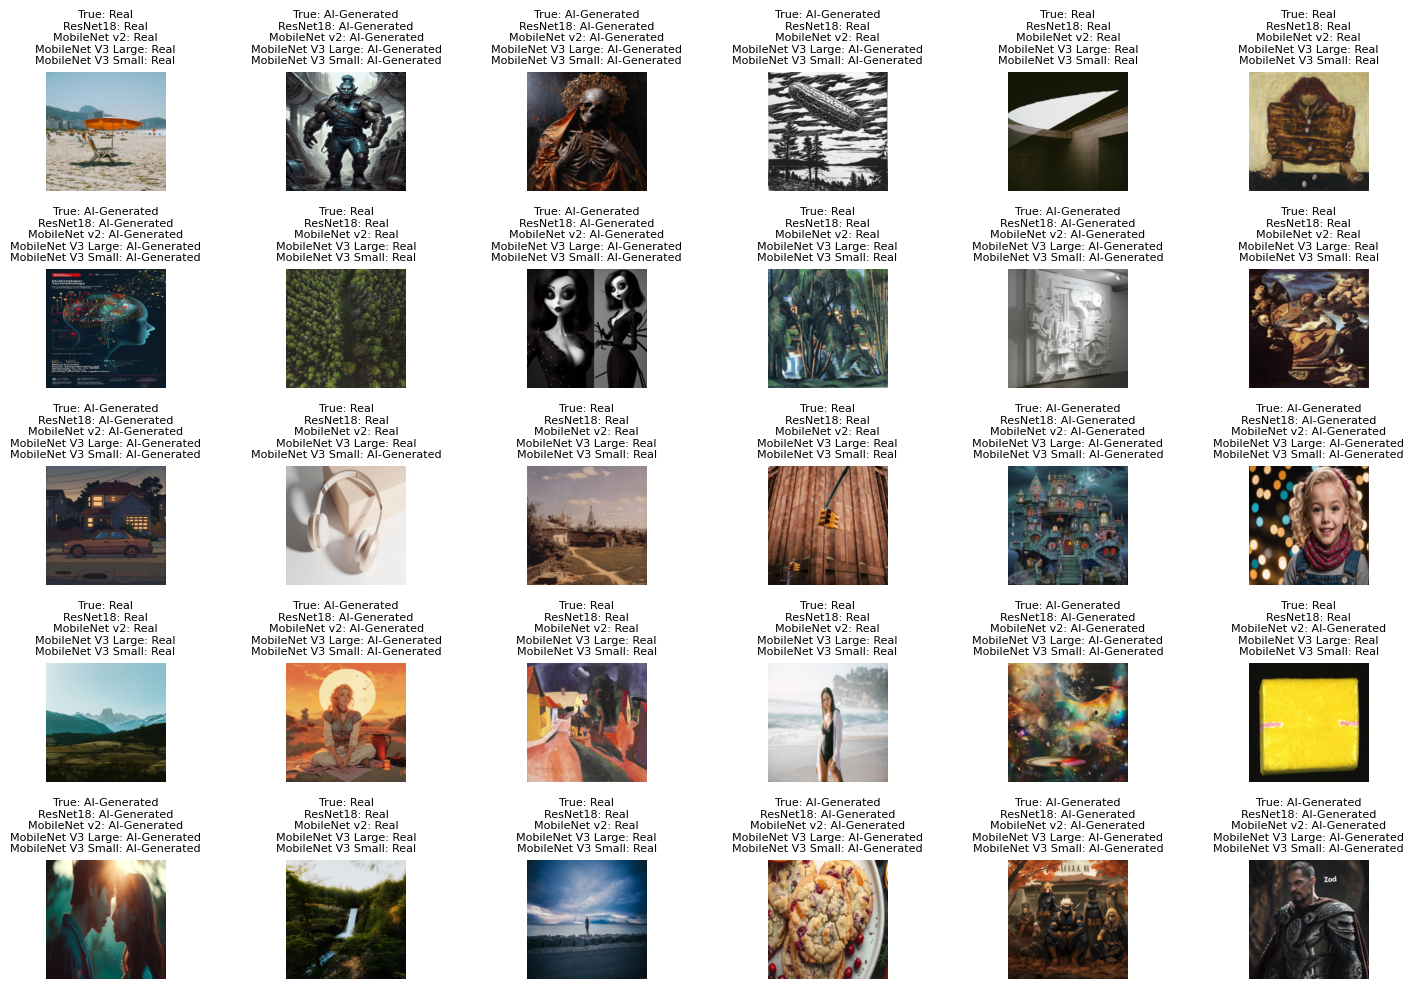

In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import random

def show_image(img, ax, title=None):
    """Displays a single image."""
    img = img.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    if title:
        ax.set_title(title, fontsize=8)
    ax.axis('off')

def predict(model, image):
    """Get predictions from a single model."""
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return pred.item()

# Prepare to collect and display results
n_rows = 5
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)  # Increase padding between images

# Randomly select 30 indices from the dataset
num_images_to_display = n_rows * n_cols
random_indices = random.sample(range(len(dataset)), num_images_to_display)

class_names = ['AI-Generated' ,'Real' ]  

for count, idx in enumerate(random_indices):
    image, true_label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    pred1 = predict(RES18_model, image)
    pred2 = predict(Mobile_model, image)
    pred3 = predict(MobileNet_V3_Large_model, image)
    pred4 = predict(MobileNet_V3_small_model, image)

    # Build the title with true label and predictions
    title = (
        f'True: {class_names[true_label]}\n'
        f'ResNet18: {class_names[pred1]}\n'
        f'MobileNet v2: {class_names[pred2]}\n'
        f'MobileNet V3 Large: {class_names[pred3]}\n'
        f'MobileNet V3 Small: {class_names[pred4]}'
    )
    
    # Show image
    ax = axes[count // n_cols, count % n_cols]
    show_image(image.cpu().squeeze(), ax, title=title)

plt.tight_layout()
plt.show()

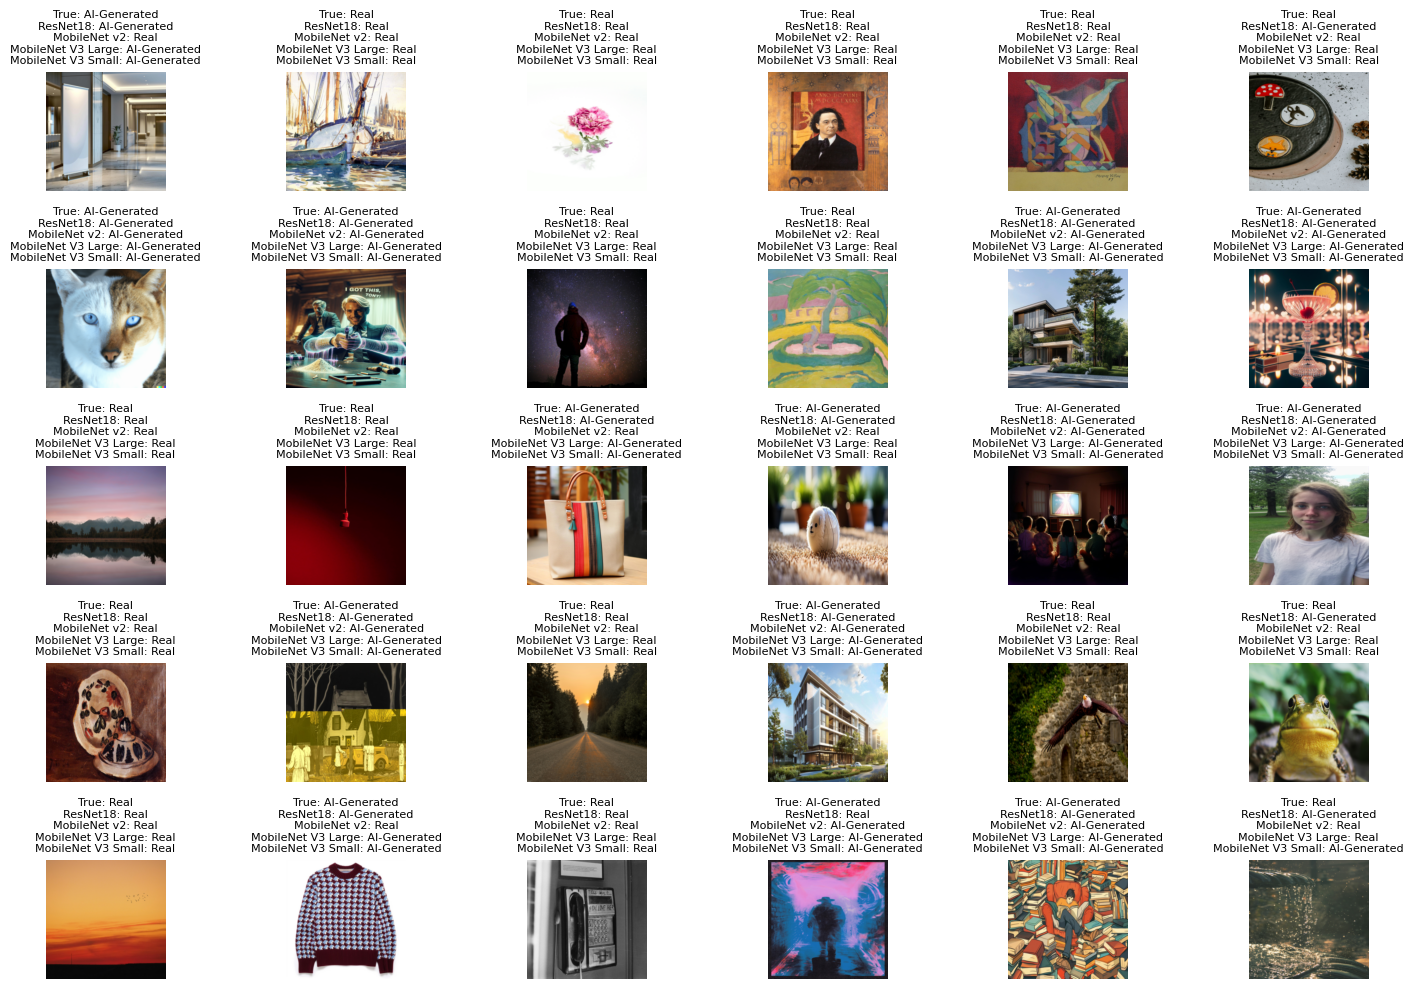

In [11]:
def show_image(img, ax, title=None):
    """Displays a single image."""
    img = img.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    if title:
        ax.set_title(title, fontsize=8)
    ax.axis('off')

def predict(model, image):
    """Get predictions from a single model."""
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return pred.item()

# Prepare to collect and display results
n_rows = 5
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)  # Increase padding between images

# Randomly select 30 indices from the dataset
num_images_to_display = n_rows * n_cols
random_indices = random.sample(range(len(dataset)), num_images_to_display)

class_names = ['AI-Generated' ,'Real' ]  

for count, idx in enumerate(random_indices):
    image, true_label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    pred1 = predict(RES18_model, image)
    pred2 = predict(Mobile_model, image)
    pred3 = predict(MobileNet_V3_Large_model, image)
    pred4 = predict(MobileNet_V3_small_model, image)

    # Build the title with true label and predictions
    title = (
        f'True: {class_names[true_label]}\n'
        f'ResNet18: {class_names[pred1]}\n'
        f'MobileNet v2: {class_names[pred2]}\n'
        f'MobileNet V3 Large: {class_names[pred3]}\n'
        f'MobileNet V3 Small: {class_names[pred4]}'
    )
    
    # Show image
    ax = axes[count // n_cols, count % n_cols]
    show_image(image.cpu().squeeze(), ax, title=title)

plt.tight_layout()
plt.show()

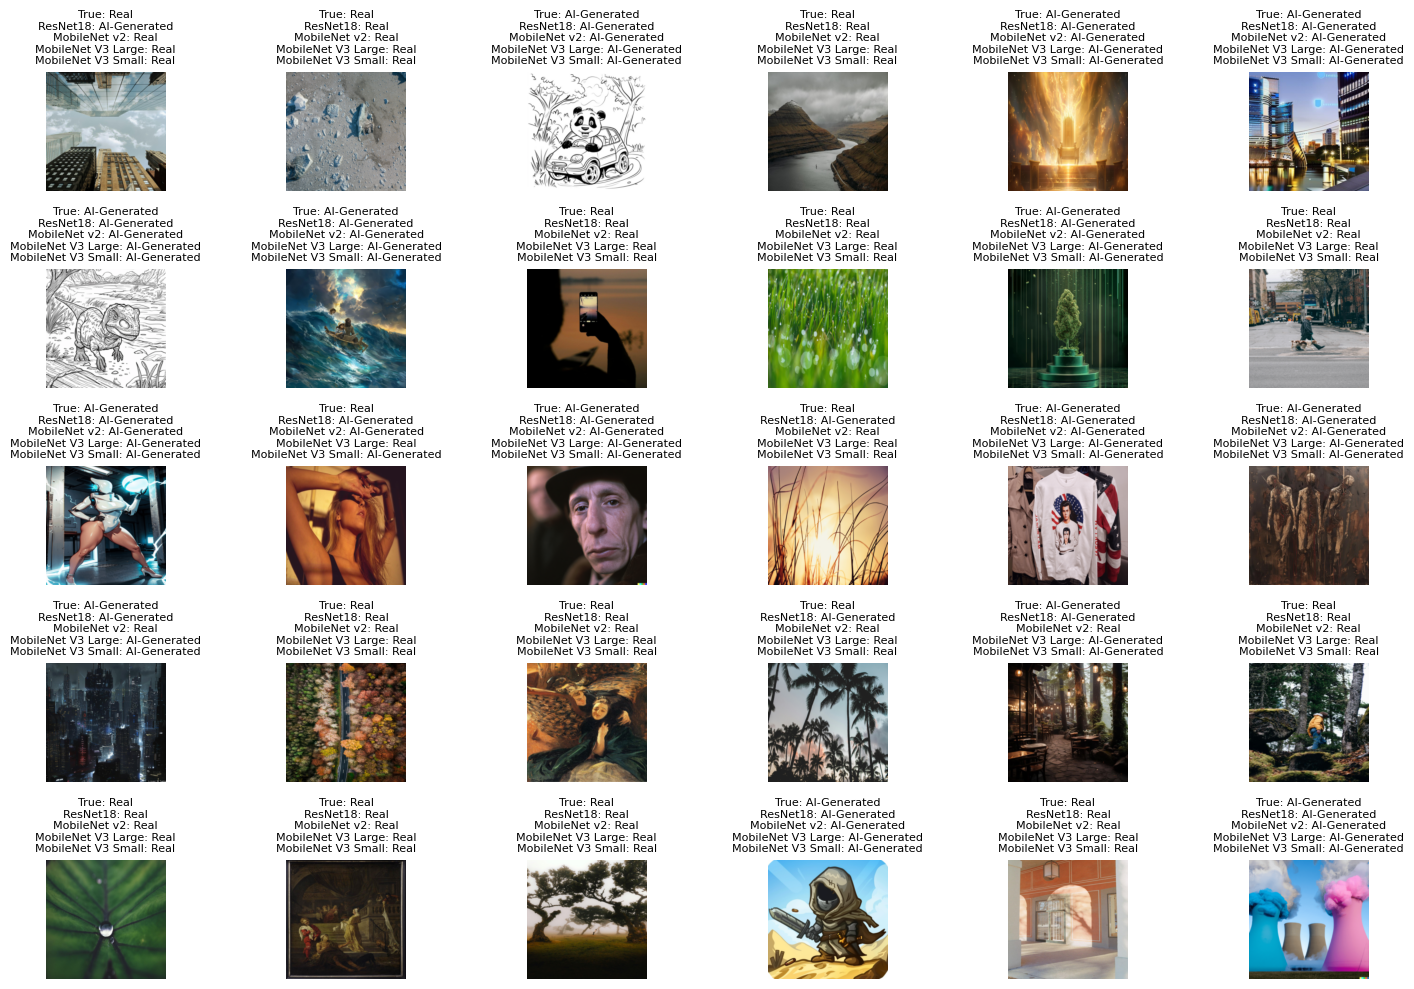

In [12]:
def show_image(img, ax, title=None):
    """Displays a single image."""
    img = img.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    if title:
        ax.set_title(title, fontsize=8)
    ax.axis('off')

def predict(model, image):
    """Get predictions from a single model."""
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
    return pred.item()

# Prepare to collect and display results
n_rows = 5
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)  # Increase padding between images

# Randomly select 30 indices from the dataset
num_images_to_display = n_rows * n_cols
random_indices = random.sample(range(len(dataset)), num_images_to_display)

class_names = ['AI-Generated' ,'Real' ]  

for count, idx in enumerate(random_indices):
    image, true_label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    pred1 = predict(RES18_model, image)
    pred2 = predict(Mobile_model, image)
    pred3 = predict(MobileNet_V3_Large_model, image)
    pred4 = predict(MobileNet_V3_small_model, image)

    # Build the title with true label and predictions
    title = (
        f'True: {class_names[true_label]}\n'
        f'ResNet18: {class_names[pred1]}\n'
        f'MobileNet v2: {class_names[pred2]}\n'
        f'MobileNet V3 Large: {class_names[pred3]}\n'
        f'MobileNet V3 Small: {class_names[pred4]}'
    )
    
    # Show image
    ax = axes[count // n_cols, count % n_cols]
    show_image(image.cpu().squeeze(), ax, title=title)

plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,confusion_matrix
from scipy.stats import mode


all_true_labels = []
all_preds_res18 = []
all_preds_res34 = []
all_preds_mobilenet_v2 = []
all_preds_MobileNet_V3_Large = []
all_preds_MobileNet_V3_Small = []


for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    all_true_labels.extend(labels.cpu().numpy())
    
    preds_res18 = RES18_model(images).argmax(dim=1).cpu().numpy()
    preds_res34 = RES34_model(images).argmax(dim=1).cpu().numpy()
    preds_mobilenet = Mobile_model(images).argmax(dim=1).cpu().numpy()
    preds_MobileNet_V3_large = MobileNet_V3_Large_model(images).argmax(dim=1).cpu().numpy()
    preds_MobileNet_V3_Small = MobileNet_V3_small_model(images).argmax(dim=1).cpu().numpy()


    all_preds_res18.extend(preds_res18)
    all_preds_res34.extend(preds_res34)
    all_preds_mobilenet_v2.extend(preds_mobilenet)
    all_preds_MobileNet_V3_Large.extend(preds_MobileNet_V3_large)
    all_preds_MobileNet_V3_Small.extend(preds_MobileNet_V3_Small)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:

all_true_labels = np.array(all_true_labels) 
all_preds_res18 = np.array(all_preds_res18)
all_preds_res34 = np.array(all_preds_res34)
all_preds_mobilenet_v2 = np.array(all_preds_mobilenet_v2)
all_preds_MobileNet_V3_Large = np.array(all_preds_MobileNet_V3_Large)
all_preds_MobileNet_V3_Small = np.array(all_preds_MobileNet_V3_Small)


combined_preds = mode(np.array([all_preds_res18, all_preds_mobilenet_v2, all_preds_MobileNet_V3_Large ,all_preds_MobileNet_V3_Small]), axis=0).mode

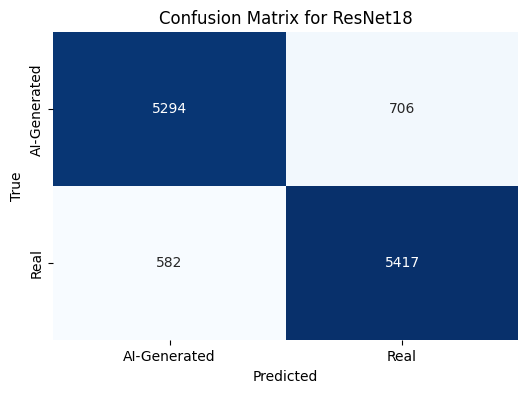

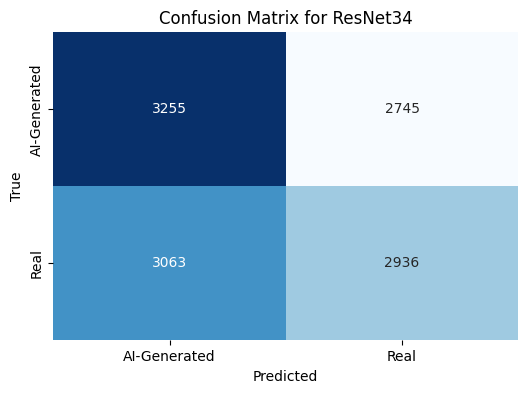

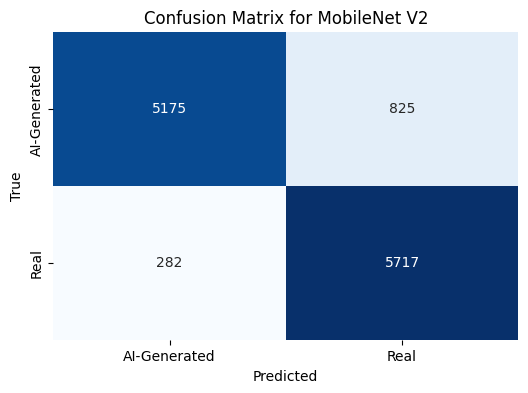

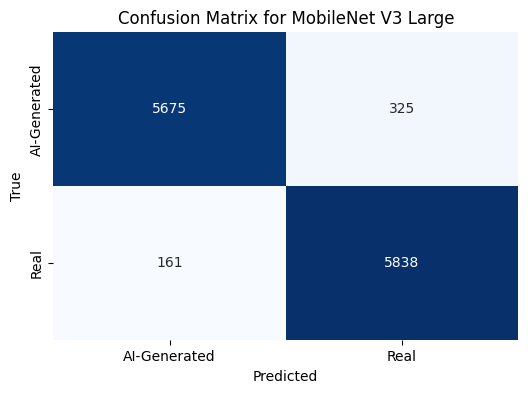

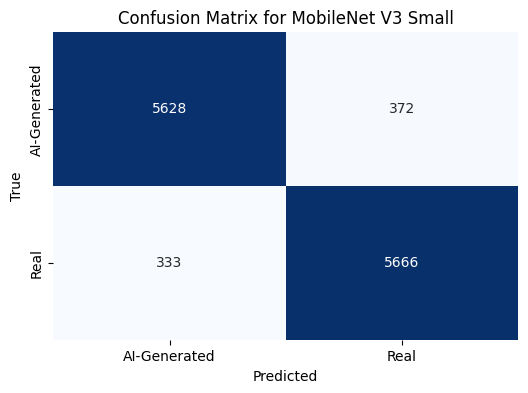

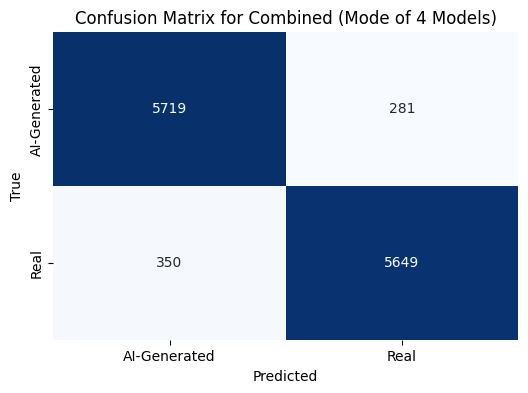

In [18]:
def plot_confusion_matrix(true_labels, predictions, model_name, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

class_names = ['AI-Generated' ,'Real']

# Plot confusion matrices for each model
plot_confusion_matrix(all_true_labels, all_preds_res18, "ResNet18", class_names)
plot_confusion_matrix(all_true_labels, all_preds_res34, "ResNet34", class_names)
plot_confusion_matrix(all_true_labels, all_preds_mobilenet_v2, "MobileNet V2", class_names)
plot_confusion_matrix(all_true_labels, all_preds_MobileNet_V3_Large, "MobileNet V3 Large", class_names)
plot_confusion_matrix(all_true_labels, all_preds_MobileNet_V3_Small, "MobileNet V3 Small", class_names)
plot_confusion_matrix(all_true_labels, combined_preds, "Combined (Mode of 4 Models)", class_names)

In [19]:
def calculate_scores(true_labels, predictions, model_name):
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")


calculate_scores(all_true_labels, all_preds_res18, "ResNet18")
calculate_scores(all_true_labels, all_preds_res34, "ResNet34")
calculate_scores(all_true_labels, all_preds_mobilenet_v2, "MobileNet V2")
calculate_scores(all_true_labels, all_preds_MobileNet_V3_Large, "MobileNet V3 Large")
calculate_scores(all_true_labels, all_preds_MobileNet_V3_Small, "MobileNet V3 Small")



calculate_scores(all_true_labels, combined_preds, "Combined (Mode of 4 Models)")

ResNet18 - Accuracy: 0.8927, Recall: 0.8927, Precision: 0.8928, F1 Score: 0.8926
ResNet34 - Accuracy: 0.5160, Recall: 0.5160, Precision: 0.5160, F1 Score: 0.5156
MobileNet V2 - Accuracy: 0.9077, Recall: 0.9077, Precision: 0.9111, F1 Score: 0.9076
MobileNet V3 Large - Accuracy: 0.9595, Recall: 0.9595, Precision: 0.9598, F1 Score: 0.9595
MobileNet V3 Small - Accuracy: 0.9412, Recall: 0.9412, Precision: 0.9413, F1 Score: 0.9412
Combined (Mode of 4 Models) - Accuracy: 0.9474, Recall: 0.9474, Precision: 0.9475, F1 Score: 0.9474


# Enhance the results

In [20]:
def calculate_scores(true_labels, predictions, model_name):
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    return [model_name, accuracy, recall, precision, f1]

results = []
results.append(calculate_scores(all_true_labels, all_preds_res18, "ResNet18"))
results.append(calculate_scores(all_true_labels, all_preds_res34, "ResNet34"))
results.append(calculate_scores(all_true_labels, all_preds_mobilenet_v2, "MobileNet V2"))
results.append(calculate_scores(all_true_labels, all_preds_MobileNet_V3_Large, "MobileNet V3 Large"))
results.append(calculate_scores(all_true_labels, all_preds_MobileNet_V3_Small, "MobileNet V3 Small"))
results.append(calculate_scores(all_true_labels, combined_preds, "Combined (Mode of 4 Models)"))

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

print(results_df_sorted)

                         Model  Accuracy    Recall  Precision  F1 Score
3           MobileNet V3 Large  0.959497  0.959497   0.959840  0.959489
5  Combined (Mode of 4 Models)  0.947412  0.947412   0.947471  0.947411
4           MobileNet V3 Small  0.941245  0.941245   0.941264  0.941244
2                 MobileNet V2  0.907742  0.907742   0.911111  0.907553
0                     ResNet18  0.892658  0.892658   0.892826  0.892646
1                     ResNet34  0.515960  0.515960   0.516002  0.515618


In [21]:
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

print(results_df_sorted)

                         Model  Accuracy    Recall  Precision  F1 Score
3           MobileNet V3 Large  0.959497  0.959497   0.959840  0.959489
5  Combined (Mode of 4 Models)  0.947412  0.947412   0.947471  0.947411
4           MobileNet V3 Small  0.941245  0.941245   0.941264  0.941244
2                 MobileNet V2  0.907742  0.907742   0.911111  0.907553
0                     ResNet18  0.892658  0.892658   0.892826  0.892646
1                     ResNet34  0.515960  0.515960   0.516002  0.515618


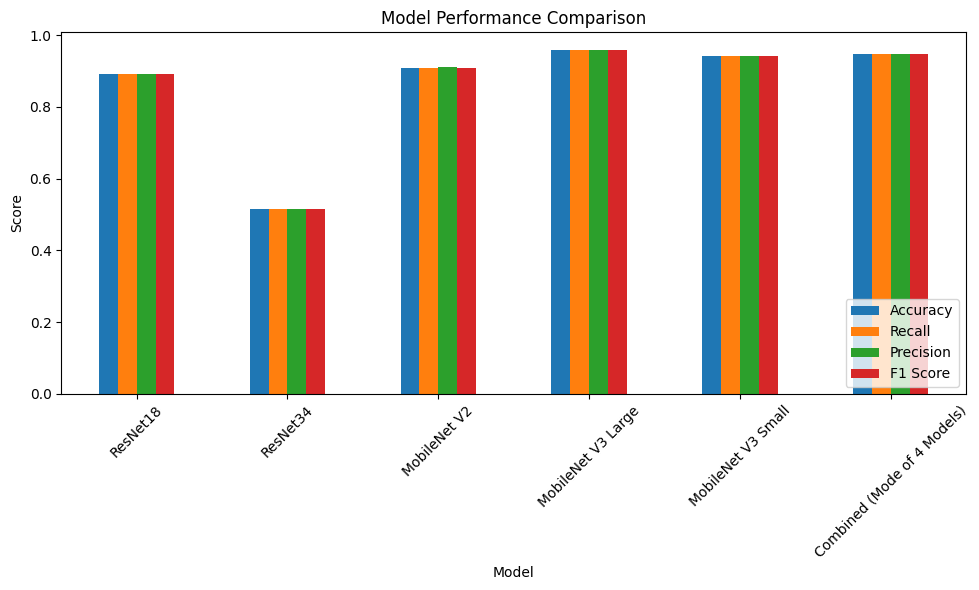

In [22]:
results_df.set_index('Model', inplace=True)
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

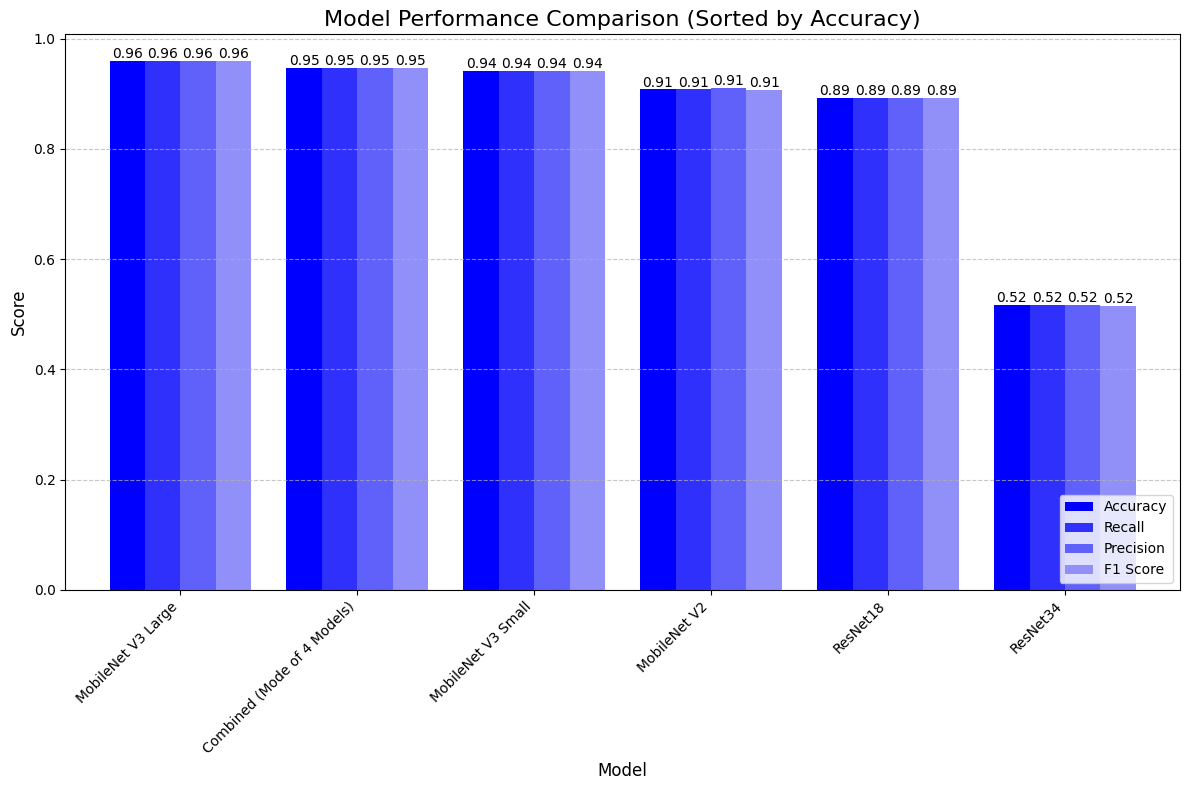

In [23]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])



results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)


plt.figure(figsize=(12, 8))
colors = sns.light_palette("blue", n_colors=len(results_df_sorted), reverse=True)
results_df_sorted.set_index('Model', inplace=True)
ax = results_df_sorted.plot(kind='bar', color=colors, figsize=(12, 8), width=0.8)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Model Performance Comparison (Sorted by Accuracy)', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
ss